<a href="https://colab.research.google.com/github/NafisMolla/CarND-LaneLines-P1_Molla/blob/master/nmolla_ece495_assignment3_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 493 Assignment 3

Assignment Overview
- Learn pytorch and helper libraries
- Understand VOC Sementic Segmentation Dataset
- Create data transforms to augment the dataset
- Create the neural network
- Train and evaluate the neural network

Problems:
- 1) Data augmentation
- 2) Create the neural network

Note:
- This assignment was created based on assignment 4 of CS 484
 - https://cs.uwaterloo.ca/~yboykov/Courses/cs484/

# Importing libraries


In [1]:
# pytorch library
import torch
# neural network layers (Conv2d, Linear, etc.) that will be trained
# https://pytorch.org/docs/stable/nn.html
import torch.nn as nn
# Many functions (convolution, pooling, activation, etc.)
# https://pytorch.org/docs/stable/nn.functional.html
import torch.nn.functional as F
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision.datasets import VOCSegmentation

# Contains pretrained models for transfer learning
# https://pytorch.org/docs/stable/torchvision/models.html
import torchvision.models as models
# import data transforms
# https://pytorch.org/docs/stable/torchvision/transforms.html
# Take note of transforms.ToPILImage and transforms.ToTensor
import torchvision.transforms as transforms
import torchvision.transforms.functional as F


# Use cuda on the gpu or use the cpu
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# Overide device when testing on CPU
# device = 'cpu'

# graphing and images
import matplotlib.pyplot as plt
from PIL import Image

# numpy
import numpy as np

# deepcopy the nn
import copy

# for random number generation
import random

# Import VOC Segmentation Dataset

Here we download the VOC segmentation dataset. This may take a while ... (~30min-1hour)

In [2]:
import os.path
from os import path
from google.colab import drive

drive.mount('/content/gdrive')
DATASET_LOCATION = '/content/gdrive/MyDrive/'

VOC_ROOT = DATASET_LOCATION

# Check if the dataset has been downloaded already.
voc_path = path.join(DATASET_LOCATION, 'VOCdevkit', 'VOC2012')
if not path.exists(voc_path):
    print('First time run, downloading VOC...')
    voc_train_data = datasets.VOCSegmentation(
        root=VOC_ROOT,
        year='2012',
        image_set='train',
        download=True
    )
else:
    voc_train_data = datasets.VOCSegmentation(
        root=VOC_ROOT,
        year='2012',
        image_set='train',
        download=False
    )

print("Number of training examples:", len(voc_train_data))

# Get the first sample to inspect the types and shapes.
sample_img, sample_target = voc_train_data[0]
print("Image type:", type(sample_img), "Target type:", type(sample_target))
print("Image shape (as numpy array):", np.array(sample_img).shape)
print("Segmented Image shape (as numpy array):", np.array(sample_target).shape)

Mounted at /content/gdrive
Number of training examples: 1464
Image type: <class 'PIL.Image.Image'> Target type: <class 'PIL.PngImagePlugin.PngImageFile'>
Image shape (as numpy array): (281, 500, 3)
Segmented Image shape (as numpy array): (281, 500)


There are 22 Classes in VOC.

https://github.com/NVIDIA/DIGITS/blob/master/examples/semantic-segmentation/pascal-voc-classes.txt
- -1 is ignore
- 0 is background
- 1-20 are different objects

Note: the ignore class is originally 255 in the label masks, but is remapped to -1

View count of pixels within each label category (sample 119):
(array([-1,  0,  7, 15]), array([  4943, 142234,  15733,   3590]))
View count of pixels within each label category (sample 273):
(array([-1,  0,  7, 15]), array([  3684, 150374,  32709,    733]))
View count of pixels within each label category (sample 225):
(array([-1,  0,  2,  7, 15]), array([ 12802, 164053,   4518,    673,   5454]))
Lastly let's verify that the image and gt label match


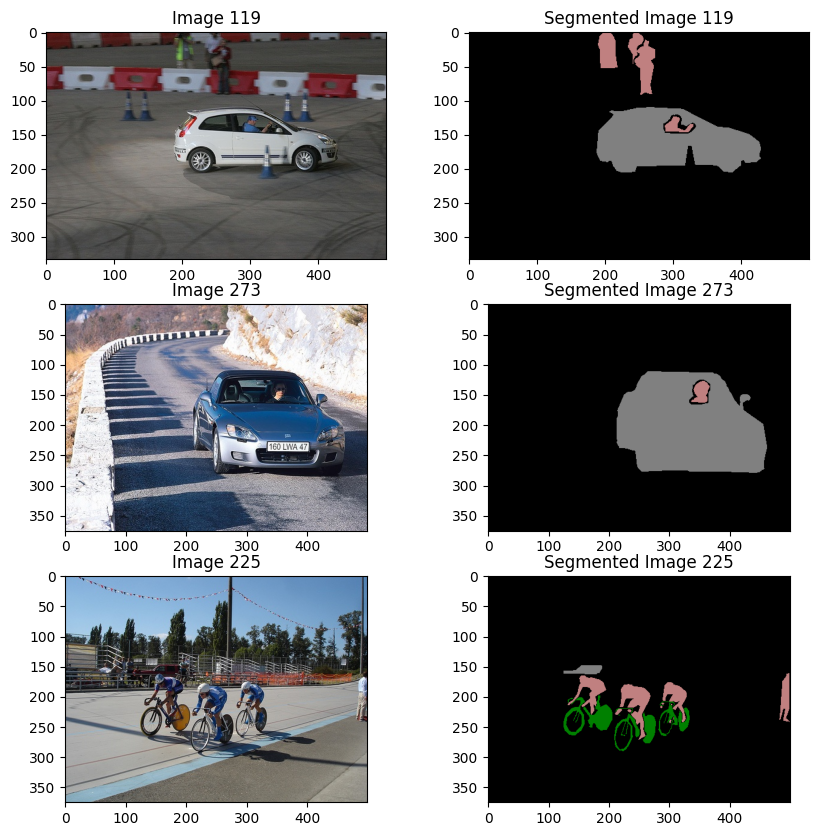

In [3]:
# Find images with people and cars
def find_car_and_ppl_images():
    car_label = 7
    person_label = 15
    count = 0
    max_count = 100
    for i in range(len(voc_train_data)):
        tmp_count = np.unique(voc_train_data[i][1], return_counts=True)
        if car_label in tmp_count[0] and person_label in tmp_count[0]:
            if count == max_count:
                break
            else:
                img, label = voc_train_data[i]
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)
                plt.title('Image ' + str(i))
                ax.imshow(np.rollaxis(img.astype(int), 0, 3))
                count += 1

# Some relevant image indexes for a self-driving car
# Car = 119, 273, Bicycle = 225
img_119, seg_img_119 = voc_train_data[119]
img_273, seg_img_273 = voc_train_data[273]
img_225, seg_img_225 = voc_train_data[225]

img_119, seg_img_119 = np.array(img_119), np.array(seg_img_119).astype(np.int64)
img_273, seg_img_273 = np.array(img_273), np.array(seg_img_273).astype(np.int64)
img_225, seg_img_225 = np.array(img_225), np.array(seg_img_225).astype(np.int64)

# Remap background class from 255 to -1
seg_img_119[seg_img_119 == 255] = -1
seg_img_273[seg_img_273 == 255] = -1
seg_img_225[seg_img_225 == 255] = -1

print("View count of pixels within each label category (sample 119):")
print(np.unique(seg_img_119, return_counts=True))
print("View count of pixels within each label category (sample 273):")
print(np.unique(seg_img_273, return_counts=True))
print("View count of pixels within each label category (sample 225):")
print(np.unique(seg_img_225, return_counts=True))

print("Lastly let's verify that the image and gt label match")

# # This colorize_mask class takes in a numpy segmentation mask,
# #  and then converts it to a PIL Image for visualization.
# #  Since by default the numpy matrix contains integers from
# #  0,1,...,num_classes, we need to apply some color to this
# #  so we can visualize easier! Refer to:
# #  https://pillow.readthedocs.io/en/4.1.x/reference/Image.html#PIL.Image.Image.putpalette
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

def add_img_plot(fig, index, img, title, sub_plot_id):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.imshow(img)

# Create the figure size
fig = plt.figure(figsize=(10,10))
# Car image 119
add_img_plot(fig, 119, img_119.astype(int), 'Image ', [3,2,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119), 'Segmented Image ', [3,2,2])
# Car image 273
add_img_plot(fig, 273, img_273.astype(int), 'Image ', [3,2,3])
add_img_plot(fig, 273, colorize_mask(seg_img_273), 'Segmented Image ', [3,2,4])
# Bicycle image 225
add_img_plot(fig, 225, img_225.astype(int), 'Image ', [3,2,5])
add_img_plot(fig, 225, colorize_mask(seg_img_225), 'Segmented Image ', [3,2,6])

# Problem 1 Data Augmentation

The transform below is used to create a transformed training dataset. It currently center crops all images.

Modify it so that:
- There is a 50% chance the images will be flipped horizontally
- Instead of a center crop, a random part of the image is cropped

Useful functions:
- torchvision.transforms.RandomHorizontalFlip
- torchvision.transforms.RandomCrop

Note: The output image and segmented images should match

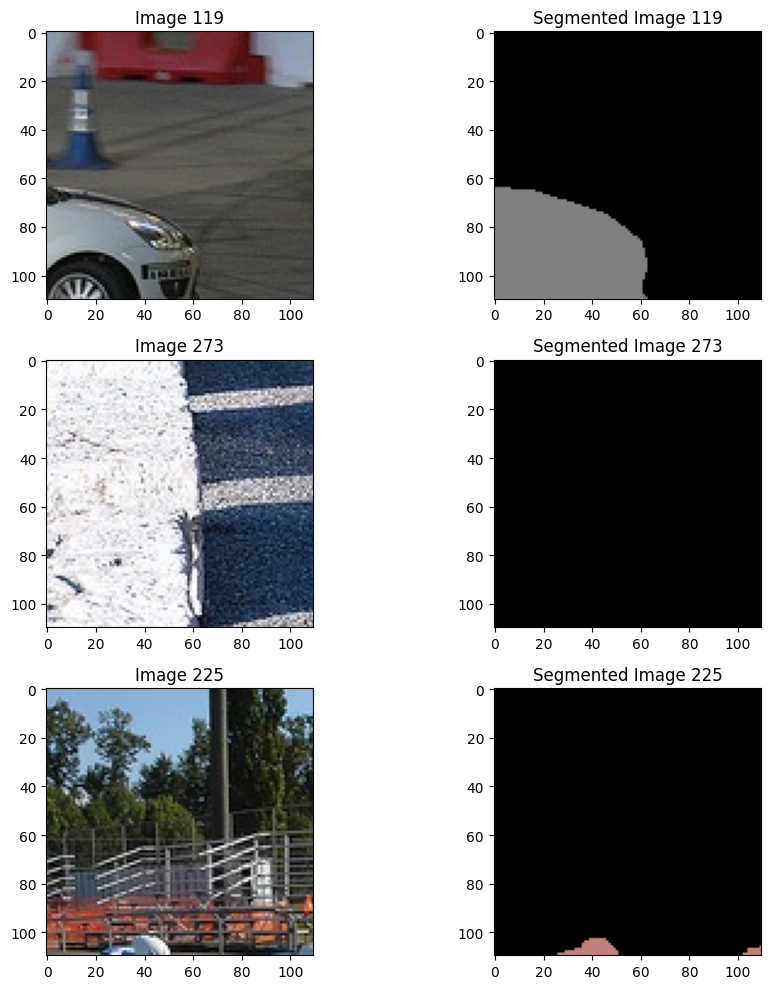

In [4]:
# Define the normalization parameters (from ImageNet)
norm = ([0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])

def tensor_to_img(tensor):
    # Denormalize tensor and convert to uint8 np array for visualization
    denormalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(norm[0], norm[1])],
        std=[1.0 / s for s in norm[1]]
    )
    np_img = np.moveaxis((denormalize(tensor).numpy() * 255), -3, -1).astype(np.uint8)
    return np_img

# Modified transform function using torchvision
def voc_train_transform(in_data):
    size = (110, 110)
    # in_data is expected to be a tuple of two PIL Images: (image, segmentation mask)
    img, seg_img = in_data

    # TODO: 50% chance the images will be flipped horizontally
    if random.random() < 0.5:
        img = transforms.RandomHorizontalFlip(p=1)(img)
        seg_img = transforms.RandomHorizontalFlip(p=1)(seg_img)

    # TODO: Instead of a center crop, a random part of the image is cropped
    i, j, h, w = transforms.RandomCrop.get_params(img, size)
    img = F.crop(img, i, j, h, w)
    seg_img = F.crop(seg_img, i, j, h, w)

    # Convert the image to tensor and normalize
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(norm[0], norm[1])(img)

    seg_img = np.array(seg_img, dtype=np.int64)
    seg_img[seg_img == 255] = -1  # Replace 255 (ignore index in VOC) with -1

    # Convert the segmentation mask to a numpy array and then to a torch tensor.
    seg_img = torch.from_numpy(seg_img)

    return img, seg_img.long()

# Assuming voc_train_data is your torchvision VOCSegmentation dataset,
# which returns a tuple of two PIL Images (img, seg_img)
img_119, seg_img_119 = voc_train_transform(voc_train_data[119])
img_273, seg_img_273 = voc_train_transform(voc_train_data[273])
img_225, seg_img_225 = voc_train_transform(voc_train_data[225])

# Create the figure for visualization (using your previously defined add_img_plot and colorize_mask)
fig = plt.figure(figsize=(10,10))
# Car image 119
add_img_plot(fig, 119, tensor_to_img(img_119), 'Image ', [3,2,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119.numpy()), 'Segmented Image ', [3,2,2])
# Car image 273
add_img_plot(fig, 273, tensor_to_img(img_273), 'Image ', [3,2,3])
add_img_plot(fig, 273, colorize_mask(seg_img_273.numpy()), 'Segmented Image ', [3,2,4])
# Bicycle image 225
add_img_plot(fig, 225, tensor_to_img(img_225), 'Image ', [3,2,5])
add_img_plot(fig, 225, colorize_mask(seg_img_225.numpy()), 'Segmented Image ', [3,2,6])
plt.tight_layout()
plt.show()

# Dataloader

In [5]:
# Define a custom dataset wrapper to apply both image and segmentation transformations
class VOCSegmentationTransformed(VOCSegmentation):
    def __init__(self, root, year="2012", image_set="train", download=False, transform=None):
        super().__init__(root, year=year, image_set=image_set, download=download)
        self.transform = transform

    def __getitem__(self, index):
        img, seg_img = super().__getitem__(index)
        if self.transform: # Apply our transformation
            img, seg_img = self.transform((img, seg_img))
        return img, seg_img  # Return transformed image and mask


voc_train_data_transformed = VOCSegmentationTransformed(root=DATASET_LOCATION, transform=voc_train_transform, image_set="train")

# epoch = one iteration over the entire dataset
# batch size = samples per batch within an epoch
# shuffle = Set to True if your data is ordered
# num_workers = number of subprocess to use when dataloading, set higher if you have many cpu cores
if device == 'cpu':
    train_loader = DataLoader(voc_train_data_transformed, batch_size=5, shuffle=True, num_workers=10)
else:
    train_loader = DataLoader(voc_train_data_transformed, batch_size=50, shuffle=True, num_workers=2)

# Problem 2 Create the neural network

In [8]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes

        # Hints:
        # Useful layers:
        # - nn.Conv2d
        # - nn.BatchNorm2d
        # - nn.Dropout2d


        # Additional convolutional layers
        self.conv7 = nn.Conv2d(in_channels=(128+512), out_channels=128, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(num_features=128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu7 = nn.ReLU()
        self.drop7 = nn.Dropout2d()

        self.final_conv = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=1)

        # Import a pre-trained encoder
        self.resnet = models.resnet34(pretrained=True)

    def forward(self, inp):
        # Fill in model to produce lfinal

        # Hints: Useful functions
        # - F.relu        (neuron activation)
        # - F.interpolate (interpolate to increase tensor H and W)
        # - torch.cat     (concatenate tensors to implement a skip connection)

        # Return the final prediction
        h0, w0 = inp.shape[2], inp.shape[3]

        # Initial processing
        x0 = self.resnet.conv1(inp)
        x0 = self.resnet.bn1(x0)
        x0 = self.resnet.relu(x0)
        x0 = self.resnet.maxpool(x0)

        # ResNet backbone processing
        x1 = self.resnet.layer1(x0)
        x2 = self.resnet.layer2(x1)
        x3 = self.resnet.layer3(x2)
        x4 = self.resnet.layer4(x3)

        # Upsample and concatenate features
        x_up = torch.nn.functional.interpolate(x4, size=x2.shape[2:], mode='bilinear', align_corners=True)
        x_cat = torch.cat([x_up, x2], dim=1)

        # Apply additional convolutional layers
        x_conv = self.conv7(x_cat)
        x_conv = self.bn7(x_conv)
        x_conv = self.relu7(x_conv)
        x_conv = self.drop7(x_conv)

        # Final upsampling and prediction
        x_final = torch.nn.functional.interpolate(x_conv, size=(h0, w0), mode='bilinear', align_corners=True)
        output = self.final_conv(x_final)

        return output

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 128MB/s]


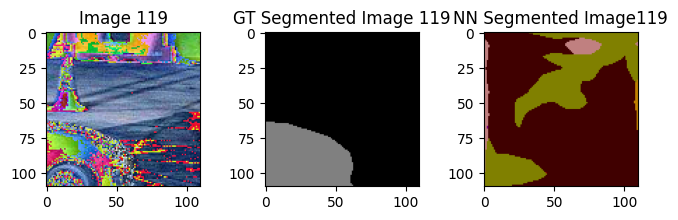

In [9]:
untrained_net = Net(21).to(device)
untrained_net.eval()

sample_img, sample_target = voc_train_data_transformed[119]

untrained_output = untrained_net.forward(sample_img[None].to(device))
if device != 'cpu':
    untrained_output = untrained_output.cpu()
untrained_nn_seg_img_119 = torch.argmax(untrained_output.cpu(), dim=1).numpy()[0]

# Create the figure size
fig = plt.figure(figsize=(8,2))
# Car image 119
add_img_plot(fig, 119, transforms.ToPILImage()(img_119), 'Image ', [1,3,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119.numpy()), 'GT Segmented Image ', [1,3,2])
add_img_plot(fig, 119, colorize_mask(untrained_nn_seg_img_119), 'NN Segmented Image', [1,3,3])

In [10]:
def train(train_loader, net, criterion, optimizer, loss_graph, device):

    for batch_idx, (data, target) in enumerate(train_loader):
        img, gt_seg_img = data.to(device), target.to(device)

        # This is a forward pass which also returns loss due to training mode
        output = net(img)
        loss = criterion(output, gt_seg_img)

        # Populate this list to graph the loss
        loss_graph.append(loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss

In [ ]:
%%time
%matplotlib inline

# Deep copy in order to train the network with the same initialized weights
trained_net = copy.deepcopy(untrained_net)
trained_net = trained_net.to(device)

# set loss function for the net
criterion = nn.CrossEntropyLoss(ignore_index=-1)

# You can change the number of EPOCHS
EPOCH = 40

# switch to train mode (original untrained_net was set to eval mode)
trained_net.train()

# You may switch the optimizer and tune the hyperparmeters
optimizer = torch.optim.SGD(trained_net.parameters(),
                            lr=0.001,
                            weight_decay=1e-5,
                            momentum=0.9,
                            nesterov=False)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_loader, trained_net, criterion, optimizer, loss_graph, device)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for trained net')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

Starting Training...


In [ ]:
def eval_semantic_segmentation(pred_labels, gt_labels):
    # Borrowed from: https://github.com/chainer/chainercv/blob/master/chainercv/evaluations/eval_semantic_segmentation.py
    pred_labels, gt_labels = iter(pred_labels), iter(gt_labels)
    n_class = 0
    confusion = np.zeros((n_class, n_class), dtype=np.int64)

    for pred, gt in zip(pred_labels, gt_labels):
        if pred.shape != gt.shape or pred.ndim != 2:
            raise ValueError("Mismatch in shape or dimension.")
        pred, gt = pred.flatten(), gt.flatten()
        lb_max = max(pred.max(), gt.max())

        if lb_max >= n_class:
            expanded = np.zeros((lb_max + 1, lb_max + 1), dtype=np.int64)
            expanded[:n_class, :n_class] = confusion
            n_class, confusion = lb_max + 1, expanded

        mask = gt >= 0
        confusion += np.bincount(n_class * gt[mask] + pred[mask], minlength=n_class**2).reshape((n_class, n_class))

    iou_den = confusion.sum(axis=1) + confusion.sum(axis=0) - np.diag(confusion)
    iou = np.diag(confusion) / iou_den
    pixel_acc = np.diag(confusion).sum() / confusion.sum()
    class_acc = np.diag(confusion) / confusion.sum(axis=1)

    return {'iou': iou, 'miou': np.nanmean(iou), 'pixel_accuracy': pixel_acc,
            'class_accuracy': class_acc, 'mean_class_accuracy': np.nanmean(class_acc)}

def validate(val_loader, net):
    iou_arr = []

    net.eval()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            img, gt_seg_img = data.to(device), target.to(device)

            output = net(img)

            # Convert to numpy arrays
            if device != 'cpu':
                output = output.cpu()
                gt_seg_img = gt_seg_img.cpu()
            pred = torch.argmax(output, dim=1).numpy()[0]

            gt_np = gt_seg_img.numpy()[0]

            conf = eval_semantic_segmentation(pred[None], gt_np[None])

            iou_arr.append(conf['miou'])

    return sum(iou_arr) / len(iou_arr)

# Validation

In [ ]:
def val_transform(in_data):
    size = (110, 110)
    img, seg_img = in_data  # PIL images

    # Center crop
    img = F.center_crop(img, size)
    seg_img = F.center_crop(seg_img, size)

    # Convert image to tensor & normalize
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(norm[0], norm[1])(img)

    # Convert segmentation mask to tensor (with ignored label correction)
    seg_img = np.array(seg_img, dtype=np.int64)
    seg_img[seg_img == 255] = -1  # Replace ignore index 255 with -1
    seg_img = torch.from_numpy(seg_img)  # Convert to PyTorch tensor

    return img, seg_img.long()

voc_val_data_transformed = VOCSegmentationTransformed(root=DATASET_LOCATION, transform=voc_train_transform, image_set="val")

# epoch = one iteration over the entire dataset
# batch size = samples per batch within an epoch
# shuffle = Set to True if your data is ordered
# num_workers = number of subprocess to use when dataloading, set higher if you have many cpu cores
val_loader = DataLoader(voc_val_data_transformed, batch_size=1, shuffle=True, num_workers=10)

In [ ]:
%%time
print("mIoU over the training dataset:{}".format(validate(train_loader, trained_net)))

In [ ]:
%%time
print("mIoU over the validation dataset:{}".format(validate(val_loader, trained_net)))

In [ ]:
# switch back to evaluation mode
trained_net.eval()

def add_img_txt_plot(fig, index, img, title, sub_plot_id, txt):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.text(10, 25, 'mIoU = {:_>8.6f}'.format(txt), fontsize=20, color='white')
    ax.imshow(img)

def get_nn_seg_img(net, data):
    img, gt_seg_img = data
    print(img_119.shape)

    nn_seg_output = net.forward(img[None].cuda())

    # computing mIOU (quantitative measure of accuracy for network predictions)
    if device != 'cpu':
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).cpu().numpy()[0]
    else:
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).numpy()[0]

    gts = gt_seg_img.cpu().numpy()

    conf = eval_semantic_segmentation(nn_seg_img[None], gts[None])

    print("View count of pixels within each label category:")
    print(np.unique(gt_seg_img, return_counts=True))
    print(np.unique(nn_seg_img, return_counts=True))

    return nn_seg_img, conf['miou']

# Some relevant image indexes for a self-driving car
# Car = 119, 273, Bicycle = 225

img_119, seg_img_119 = val_transform(voc_train_data[119])
img_273, seg_img_273 = val_transform(voc_train_data[273])
img_225, seg_img_225 = val_transform(voc_train_data[225])

# Get NN Output
nn_seg_img_119, miou_119 = get_nn_seg_img(trained_net, val_transform(voc_train_data[119]))
nn_seg_img_273, miou_273 = get_nn_seg_img(trained_net, val_transform(voc_train_data[273]))
nn_seg_img_225, miou_225 = get_nn_seg_img(trained_net, val_transform(voc_train_data[225]))

# Create the figure size
fig = plt.figure(figsize=(20,15))
# Car image 119
add_img_plot(fig, 119, tensor_to_img(img_119), 'Image ', [3,3,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119.numpy()), 'GT Segmented Image ', [3,3,2])
add_img_txt_plot(fig, 119, colorize_mask(nn_seg_img_119), 'NN Segmented Image ', [3,3,3], miou_119)
# Car image 273
add_img_plot(fig, 273, tensor_to_img(img_273), 'Image ', [3,3,4])
add_img_plot(fig, 273, colorize_mask(seg_img_273.numpy()), 'Segmented Image ', [3,3,5])
add_img_txt_plot(fig, 273, colorize_mask(nn_seg_img_273), 'NN Segmented Image ', [3,3,6], miou_273)
# Bicycle image 225
add_img_plot(fig, 225, tensor_to_img(img_225), 'Image ', [3,3,7])
add_img_plot(fig, 225, colorize_mask(seg_img_225.numpy()), 'Segmented Image ', [3,3,8])
add_img_txt_plot(fig, 225, colorize_mask(nn_seg_img_225), 'NN Segmented Image ', [3,3,9], miou_225)

plt.show()